[INFO] loading images...
[INFO] compiling model...
[INFO] training network...
Train on 435 samples, validate on 145 samples
Epoch 1/30
435/435 [==============================] - 1s 3ms/step - loss: 0.6543 - accuracy: 0.5494 - val_loss: 0.4770 - val_accuracy: 0.8552
Epoch 2/30
435/435 [==============================] - 1s 2ms/step - loss: 0.3591 - accuracy: 0.8460 - val_loss: 0.3102 - val_accuracy: 0.8828
Epoch 3/30
435/435 [==============================] - 1s 2ms/step - loss: 0.2215 - accuracy: 0.9195 - val_loss: 0.2532 - val_accuracy: 0.9172
Epoch 4/30
435/435 [==============================] - 1s 2ms/step - loss: 0.2273 - accuracy: 0.8897 - val_loss: 0.2650 - val_accuracy: 0.9310
Epoch 5/30
435/435 [==============================] - 1s 2ms/step - loss: 0.2098 - accuracy: 0.9172 - val_loss: 0.1793 - val_accuracy: 0.9241
Epoch 6/30
435/435 [==============================] - 1s 2ms/step - loss: 0.1233 - accuracy: 0.9563 - val_loss: 0.1354 - val_accuracy: 0.9379
Epoch 7/30
435/435 [====

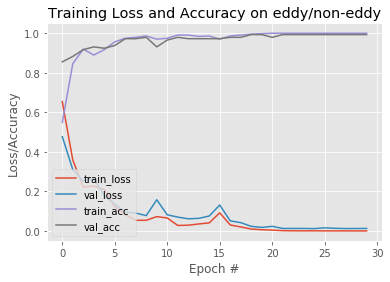

In [46]:
# classification with neural networks
# course: deep neural networks for ocean sciences
# based on: https://www.pyimagesearch.com/2017/12/11/image-classification-with-keras-and-deep-learning/
# author: Ribana Roscher

# import the necessary packages
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os

# %% data ====================================================================
# path for train data and path where model should be saved
path_images = "dataset2/train/" #dataset1:180 135+45 dataset2:580 435+145, dataset3: 607 455+152
savePath_model = ""

# initialize the data and labels
print("[INFO] loading images...")
data = []
labels = []

# grab the image paths and randomly shuffle them
imagePaths = sorted(list(paths.list_images(path_images)))
random.shuffle(imagePaths)

# loop over the input images
for imagePath in imagePaths:
	# load the image, pre-process it, and store it in the data list
	image = cv2.imread(imagePath)
	image = cv2.resize(image, (28, 28))
	image = img_to_array(image)
	data.append(image)

	# extract the class label from the image path and update the
	# labels list
	label = imagePath.split(os.path.sep)[-2]
	label = 1 if label == "eddy" else 0
	labels.append(label)

# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

# define training data
trainX = data
trainY = labels

# convert the labels from integers to vectors
trainY = to_categorical(trainY, num_classes=2)

# %% model ===================================================================
# initialize the number of epochs to train for, initial learning rate,
# and batch size
epochsVal = 30
learnRateVal = 0.001
batchSizeVal = 10

# image size (grayvalued images are treated as rgb)
width=28
height=28
depth=3
classes=2

# initialize the model
print("[INFO] compiling model...")

# initialize the model
model = Sequential()
inputShape = (height, width, depth)

# first set of CONV => RELU => POOL layers
model.add(Conv2D(20, (5, 5), padding="same",
			input_shape=inputShape))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# second set of CONV => RELU => POOL layers
model.add(Conv2D(50, (5, 5), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# first (and only) set of FC => RELU layers
model.add(Flatten())
model.add(Dense(500))
model.add(Activation("relu"))

# softmax classifier
#ADD A DENSE LAYER WITH NUMBER OF NEURONS = NUMBER OF CLASSES AND SOFTMAX ACTIVATION
model.add(Dense(2, activation='softmax'))

opt = Adam(lr=learnRateVal, decay=learnRateVal / epochsVal)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the network
print("[INFO] training network...")
H = model.fit(trainX, trainY, batch_size=batchSizeVal, epochs=epochsVal,
          validation_split=0.25, shuffle=True)

# save the model to disk
print("[INFO] saving network model...")
model.save(savePath_model + "eddy.model")

# %% plotting the results ====================================================
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
N = epochsVal
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on eddy/non-eddy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")


In [ ]:
# test

[INFO] loading network...


Text(10, 30, 'non eddy: 76.39%')

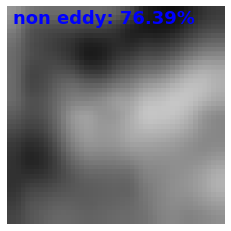

In [54]:
# import the necessary packages
from keras.preprocessing.image import img_to_array
from keras.models import load_model
import numpy as np
import imutils
import cv2
import matplotlib.pyplot as plt

# load the image
image = cv2.imread("dataset3/test/nonEddy1.png")

orig = image.copy()

# pre-process the image for classification
image = cv2.resize(image, (28, 28))
image = image.astype("float") / 255.0
image = img_to_array(image)
image = np.expand_dims(image, axis=0)

# load the trained convolutional neural network
print("[INFO] loading network...")
model = load_model("eddy.model")

# classify the input image
(nonEddy, eddy) = model.predict(image)[0]

# build the label
label = "eddy" if eddy > nonEddy else "non eddy"
proba = eddy if eddy > nonEddy else nonEddy
label = "{}: {:.2f}%".format(label, proba * 100)

# draw the label on the image
output = imutils.resize(orig, width=400)

plt.imshow(output)
#plt.text(10, 30, label, fontsize=18, color='blue', fontweight='bold')
plt.axis('off')
plt.text(10, 30, label, fontsize=18, color='blue', fontweight='bold')



[INFO] loading network...


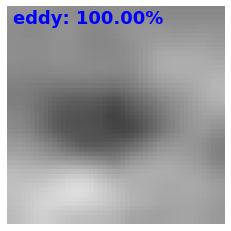

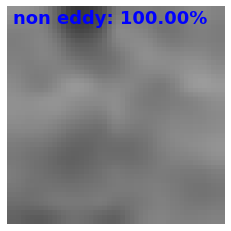

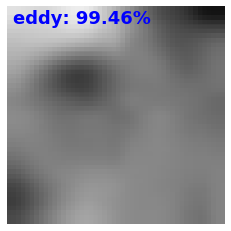

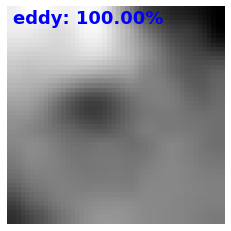

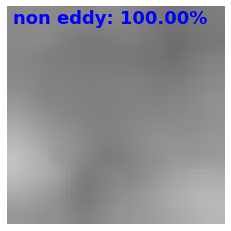

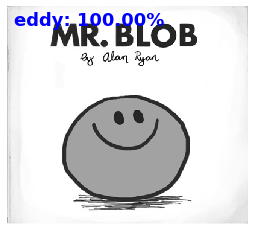

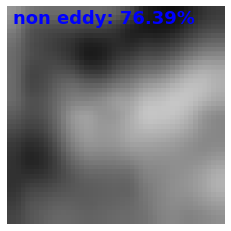

In [55]:
# import the necessary packages
from keras.preprocessing.image import img_to_array
from keras.models import load_model
import numpy as np
import imutils
import cv2
import matplotlib.pyplot as plt

######build function
# load the trained convolutional neural network
print("[INFO] loading network...")
model = load_model("eddy.model")
path_testImages = "dataset3/test/"
testImagePaths = sorted(list(paths.list_images(path_testImages)))
#for imagePath in testImagePaths:
#    my_testFunction (imagePath)
   
def my_testFunction(imagePath):
    image = cv2.imread(imagePath)
    orig = image.copy()
    # pre-process the image for classification
    image = cv2.resize(image, (28, 28))
    image = image.astype("float") / 255.0
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)



    # classify the input image
    (nonEddy, eddy) = model.predict(image)[0]

    # build the label
    label = "eddy" if eddy > nonEddy else "non eddy"
    proba = eddy if eddy > nonEddy else nonEddy
    label = "{}: {:.2f}%".format(label, proba * 100)

    # draw the label on the image
    output = imutils.resize(orig, width=400)
    plt.figure()
    plt.imshow(output)
    plt.axis('off')
    plt.text(10, 30, label, fontsize=18, color='blue', fontweight='bold')
    #return output
#

#image = cv2.imread("dataset3/test/nonEddy1.png")
#plt.imshow(my_testFunction(image))
#plt.axis('off')
#plt.text(10, 30, label, fontsize=18, color='blue', fontweight='bold')

##main
#print("[INFO] loading network...")
#model = load_model("eddy.model")
path_testImages = "dataset1/test/"
testImagePaths = sorted(list(paths.list_images(path_testImages)))
for imagePath in testImagePaths:
    my_testFunction(imagePath)
    #image = cv2.imread(imagePath)
    #plt.figure()
    #plt.imshow(my_testFunction(image))
    #plt.axis('off')
    #plt.text(10, 30, label, fontsize=18, color='blue', fontweight='bold')
#    my_testFunction (imagePath)